# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import nltk
nltk.download("stopwords", quiet=True)

True

In [4]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19961,28132,73084,Surrey - UK,26-03-2020,Isn t it interesting that nearly all essential...,Negative
973,4977,49929,"New England, USA",17-03-2020,Went to the grocery store this morning; still ...,Negative
33264,44725,89677,Kolkata,14-04-2020,@MOFPI_GOI @irvpaswan @ficci_india @PMOIndia @...,Positive
13750,20489,65441,"Cambridge, MA",22-03-2020,President can end price gauging says @DanRathe...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [9]:
df.loc[df.Sentiment.isin(['Extremely Positive', 'Positive']), 'Sentiment'] = 1
df.loc[df.Sentiment.isin(['Extremely Negative', 'Negative']), 'Sentiment'] = 0

Сбалансированы ли классы?

In [12]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** объектов примерно поровну, значит сбалансированны

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [16]:
print(df.isna().sum()) # видим много пропусков в Location
df.loc[df.Location.isnull(), 'Location'] = 'Unknown'

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [91]:
train_splitted = train.OriginalTweet.apply(lambda x: np.array(x.split()))
tokens = train_splitted.to_numpy()
tokens

array([array(['Why', 'we', 'still', 'want', 'to', 'buy', 'so', 'much', 'stuff',
              'during', 'quarantine', 'https://t.co/1m881CwFUv', '#shopping',
              '#Covid_19', '#Online'], dtype='<U23')                           ,
       array(['With', 'driving', 'even', 'more', 'usage', 'a', 'strong',
              'strategy', 'is', 'critical', 'now', 'more', 'then', 'ever',
              'Luckily', 'and', 'April', '16', 'webinar', 'will', 'dive', 'into',
              'growing', 'app', 'awareness', 'and', 'targeting', 'high',
              'lifetime', 'value', 'users'], dtype='<U9')                        ,
       array(['@Canon_India', 'I', 'am', 'very', 'happy..', 'Great', 'job', 'by',
              '@Canon_India', '#CanonForCommunity', 'https://t.co/Z0intkS34x'],
             dtype='<U23')                                                       ,
       ...,
       array(['An', 'initiative', 'taken', 'by', 'our', '@GOLDENINITIATI1', 'at',
              'khopoli,', 'Maharastr

In [93]:
tokens = np.char.lower(np.concatenate(tokens))
tokens

array(['why', 'we', 'still', ..., '#covid2019', '@680news',
       'https://t.co/7j2y3rsld9'], dtype='<U252')

In [38]:
unique_values, counts = np.unique(tokens, return_counts=True)
indexes = np.argsort(-counts).tolist()
sorted_value_counts = dict(zip(unique_values[indexes].tolist(), counts[indexes].tolist()))



In [39]:
unique_values[:10]

array(['!', '!!', '!!!', '!!!!', '!!!!!!', '!!!!!!!!', '!!!!!?????',
       '!!!???', '!#somegoodnews', '!).'], dtype='<U252')

Какой размер словаря получился?

In [41]:
len(sorted_value_counts) #79755

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [44]:
res = zip(list(sorted_value_counts)[:10], list(sorted_value_counts.values())[:10])
print(*res, sep='\n')

('the', 26815)
('to', 23373)
('and', 14684)
('of', 13012)
('a', 11737)
('in', 11198)
('for', 8566)
('#coronavirus', 8223)
('is', 7383)
('are', 7050)


**Ответ:** здесь все слова - служебные части речи, которые встречаются в предложениях вне зависимости от смысла, просто для связи, они необходимы (стоп-слова в общем). кроме того в топе #coronavirus, так как наша выборка твитов объединена общей темой - короновируса

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [47]:
from nltk.corpus import stopwords

for i in stopwords.words('english'):
  try:
    sorted_value_counts.pop(i)
  except KeyError:
    pass
res = zip(list(sorted_value_counts)[:10], list(sorted_value_counts.values())[:10])
print(*res, sep='\n')

('#coronavirus', 8223)
('prices', 3891)
('food', 3820)
('grocery', 3469)
('supermarket', 3288)
('people', 3175)
('covid-19', 3173)
('store', 3155)
('#covid19', 2471)
('&amp;', 2314)


**Ответ:**  теперь люди пишут о еде, ценах и магазинах, а также о короновирусе, с помощью разных синонимов. + добавился служебный символ. все логично, ведь в условиях самоизоляции возникла проблема невозможности ходить в магазин и все стали закупаться

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [55]:
res = zip(list(sorted_value_counts)[-20:], list(sorted_value_counts.values())[-20:])
print(*res, sep='\n')

('court-', 1)
('court.....', 1)
('courteous,;', 1)
('courtesy,', 1)
('courts.', 1)
('cousin,', 1)
('cousins,', 1)
('covenant-keeping..', 1)
('covent', 1)
('coventry', 1)
('cover.', 1)
('cover:', 1)
('coverage:', 1)
('covered!', 1)
('covered..', 1)
('covered?', 1)
('covering,', 1)
('covering.', 1)
('coversation', 1)
('ã\x83â¼berweist', 1)


**Ответ:** некоторые малоосмысленны, некоторые содеражат лишние символы, можно токены второго типа подправить и убрать эти лишние символы, но в целом можно их игнорировать - просто погрешность

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [59]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(preserve_case = False)
tw_train_splitted = train.OriginalTweet.apply(lambda x: np.array(tk.tokenize(x)))
tw_tokens = tw_train_splitted.to_numpy()
tw_tokens = np.concatenate(tw_tokens)
tw_unique_values, tw_counts = np.unique(tw_tokens, return_counts=True)
tw_indexes = np.argsort(-tw_counts).tolist()
tw_sorted_value_counts = dict(zip(tw_unique_values[tw_indexes].tolist(), tw_counts[tw_indexes].tolist()))



In [60]:
res = zip(list(tw_sorted_value_counts)[:10], list(tw_sorted_value_counts.values())[:10])
print(*res, sep='\n')

('the', 26993)
('.', 24118)
('to', 23478)
(',', 17571)
('and', 14825)
('of', 13044)
('a', 11891)
('in', 11348)
('?', 9524)
('#coronavirus', 8808)


**Ответ:** теперь в топе есть отдельные пунктуационнные символы, ведь редко кто отделяет их пробелом от слова

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [65]:
from string import punctuation

trash = stopwords.words('english') + list(punctuation)
for i in trash:
  try:
    tw_sorted_value_counts.pop(i)
  except KeyError:
    pass
res = zip(list(tw_sorted_value_counts)[:10], list(tw_sorted_value_counts.values())[:10])
print(*res, sep='\n')

('#coronavirus', 8808)
('â', 7415)
('\x82', 7311)
('19', 7167)
('covid', 6253)
('prices', 4601)
('\x92', 4372)
('food', 4367)
('store', 3877)
('supermarket', 3805)


**Ответ:** опять еда и короновирус, но есть и непонятные символы

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [69]:
s = list(tw_sorted_value_counts.keys())[:]
for i in s:
  if len(i) == 1 and ord(i)>=128:
    tw_sorted_value_counts.pop(i)


In [71]:
res = zip(list(tw_sorted_value_counts)[:10], list(tw_sorted_value_counts.values())[:10])
print(*res, sep='\n')

('#coronavirus', 8808)
('19', 7167)
('covid', 6253)
('prices', 4601)
('food', 4367)
('store', 3877)
('supermarket', 3805)
('grocery', 3523)
('people', 3463)
('#covid19', 2589)


In [73]:
res = zip(list(sorted_value_counts)[-20:], list(sorted_value_counts.values())[-20:])
print(*res, sep='\n')

('court-', 1)
('court.....', 1)
('courteous,;', 1)
('courtesy,', 1)
('courts.', 1)
('cousin,', 1)
('cousins,', 1)
('covenant-keeping..', 1)
('covent', 1)
('coventry', 1)
('cover.', 1)
('cover:', 1)
('coverage:', 1)
('covered!', 1)
('covered..', 1)
('covered?', 1)
('covering,', 1)
('covering.', 1)
('coversation', 1)
('ã\x83â¼berweist', 1)


**Ответ:** теперь в топе нет мусора в виде амперсанта, но в антитопе изменений мало, ведь мы удалили только односимвольные проблемные токены.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [77]:
hashtags = dict()
for i in tw_sorted_value_counts.keys():
  if i[0] == '#':
    hashtags[i] = tw_sorted_value_counts[i]
res = zip(list(hashtags)[:10], list(hashtags.values())[:10])
print(*res, sep='\n')

('#coronavirus', 8808)
('#covid19', 2589)
('#covid_19', 1734)
('#covid2019', 946)
('#toiletpaper', 744)
('#covid', 641)
('#socialdistancing', 465)
('#coronacrisis', 448)
('#pandemic', 257)
('#coronaviruspandemic', 249)


**Ответ:** хэштеги соответсвтвюут времени, коронавирус (разные названия), основные проблемы - туалетная бумага и самоизоляция

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [81]:
links= dict()
for i in tw_sorted_value_counts.keys():
  if i[:12] == 'https://t.co':
    links[i] = tw_sorted_value_counts[i]
res = zip(list(links)[:10], list(links.values())[:10])
print(*res, sep='\n')

('https://t.co/oXA7SWtoNd', 5)
('https://t.co/gP3EusapL8', 4)
('https://t.co/3GBBDpdjat', 3)
('https://t.co/WrLHYzIzAA', 3)
('https://t.co/DefTruI1PfÃ\x82Â', 3)
('https://t.co/WuiEEfSNOj', 3)
('https://t.co/kuwIpF1KQW', 3)
('https://t.co/zjNRx6dKKN', 3)
('https://t.co/G63RP042HO', 3)
('https://t.co/AZIqCdgrNn', 3)


**Ответ:** хэштегов тысячи, а ссылок единицы - ссылки полезны, так как это более специфичная информация, но это очень избирательный способ проверки, нужно более глобальное разделение чем выделение нескольких конкретных твитов

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [98]:
def custom_tokenizer(text):

  tk = TweetTokenizer(preserve_case = False)
  tokens = tk.tokenize(text)
  trash = stopwords.words('english') + list(punctuation)
  for i in trash:
    while i in tokens:
      tokens.remove(i)
  for i in tokens[:]:
    if len(i) == 1 and ord(i)>=128:
      tokens.remove(i)
  for i in tokens[:]:
    if i[:12] == 'https://t.co':
      tokens.remove(i)
  return tokens


In [99]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X = cv.fit_transform(train.OriginalTweet)
print(len(cv.vocabulary_))
# 45290

C:\Users\1\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


**Ответ:** словарь практически вдвое меньше стал, так как выкинули много мусора в нашем кастомном токенизаторе

Посмотрим на какой-нибудь конкретный твитт:

In [107]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [119]:
text= " ".join([w for w in custom_tokenizer(train.iloc[ind]['OriginalTweet'])])
text = cv.transform([text])
text_without_zeros = np.where(text.toarray() == 0, np.inf, text.toarray())
list(cv.get_feature_names_out())[np.argmin(text_without_zeros)], list(cv.get_feature_names_out())[np.argmax(text.toarray())]


('#coronavirusoutbreak', '#coronavirusoutbreak')

**Ответ:** он выбрал одинаковые слова, так как все слова здесь повторяются по одному разу и по сути это рандомные слова - плохо

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
X = tfidf_vec.fit_transform(train.OriginalTweet)


In [30]:
text= " ".join([w for w in custom_tokenizer(train.iloc[ind]['OriginalTweet'])])
text = tfidf_vec.transform([text])
text_without_zeros = np.where(text.toarray() == 0, np.inf, text.toarray())
list(tfidf_vec.get_feature_names_out())[np.argmin(text_without_zeros)], list(tfidf_vec.get_feature_names_out())[np.argmax(text.toarray())]


('food', 'brainless')

**Ответ:** он хорошо выбрал слово brainless, которое явно указывает на эмоциональную окраску, и вполне неплохо выбрал food - нейтральное слово. так получилось, потому что food встречается в большом количестве текстов, а brainless наоборот

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [31]:
train[train['OriginalTweet'].apply(lambda x: 'pleasure' in x) & (train['Sentiment'] == 1)]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
152,3977,48929,Unknown,16-03-2020,Taken by Henk Zwoferink on Saturday in WÃÂ¶rg...,1
5020,9906,54858,New York City area,19-03-2020,It was a pleasure to be part of such a timely ...,1


In [32]:
train.at[152, 'OriginalTweet']

"Taken by Henk Zwoferink on Saturday in WÃ\x83Â¶rgl, our black beauty hauled a train bringing the last tourists home. Our colleagues are #workinghard to keep supply chains running while respecting the measures to ensure everyone's #safety. A pleasure to work with such #DedicatedPeople! https://t.co/EoXT7Q43ZB"

In [33]:
text= " ".join([w for w in custom_tokenizer(train.at[152, 'OriginalTweet'])])
text = tfidf_vec.transform([text])
text_without_zeros = np.where(text.toarray() == 0, np.inf, text.toarray())
list(tfidf_vec.get_feature_names_out())[np.argmin(text_without_zeros)], list(tfidf_vec.get_feature_names_out())[np.argmax(text.toarray())]


('home', '#dedicatedpeople')

**Ответ:** тут неплохо определяется самое неважное слово - home - все сидят по домам, это частое слово и не несет окраски. хэштег же про преданных своему делу людей довольно естественно относить к положительно окрашеному токену, так что результат хороший

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [84]:
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfidf_vec = tfidf_vec.fit_transform(train.OriginalTweet)

cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train_cv = cv.fit_transform(train.OriginalTweet)

y_train = train.Sentiment.to_numpy().astype(int)

X_test_tfidf_vec = tfidf_vec.transform(test.OriginalTweet)

X_test_cv = cv.transform(test.OriginalTweet)

y_test = test.Sentiment.to_numpy().astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=200, random_state=52)

clf.fit(X_train_tfidf_vec, y_train)

pred_train_tfidf_vec = clf.predict(X_train_tfidf_vec)
print('X_train_tfidf_vec')
print(accuracy_score(y_train, pred_train_tfidf_vec))

clf.fit(X_train_cv, y_train)

pred_train_cv = clf.predict(X_train_cv)
print('X_train_cv')
print(accuracy_score(y_train, pred_train_cv))


pred_test_tfidf_vec = clf.predict(X_test_tfidf_vec)
print('X_test_tfidf_vec')
print(accuracy_score(y_test, pred_test_tfidf_vec))


pred_test_cv = clf.predict(X_test_cv)
print('X_test_cv')
print(accuracy_score(y_test, pred_test_cv))

X_train_tfidf_vec
0.9224263135412217
X_train_cv
0.9846646732165741
X_test_tfidf_vec
0.8512058999402033
X_test_cv
0.8670520231213873


**Ответ:**  векторайзер CountVectorizer показывает чуть лучший результат, думаю это связано с тем что другой векторайзер может присваивать важность уникальным словам типа имен и тэгов, которые не имеют отношения к окраске

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [36]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  tokens = [stemmer.stem(w) for w in custom_tokenizer(text)]
  return tokens


In [37]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [38]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit_transform(train.OriginalTweet)

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


**Ответ** ушла примерно 1/5 слов - значительное сокращение

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [81]:
X_train_tfidf_vec = tfidf_vec.fit_transform(train.OriginalTweet)

X_train_cv = cv.fit_transform(train.OriginalTweet)

y_train = train.Sentiment.to_numpy().astype(int)

X_test_tfidf_vec = tfidf_vec.transform(test.OriginalTweet)

X_test_cv = cv.transform(test.OriginalTweet)

y_test = test.Sentiment.to_numpy().astype(int)

clf = LogisticRegression(max_iter=200, random_state=52)

clf.fit(X_train_tfidf_vec, y_train)

pred_train_tfidf_vec = clf.predict(X_train_tfidf_vec)
print('X_train_tfidf_vec')
print(accuracy_score(y_train, pred_train_tfidf_vec))

clf.fit(X_train_cv, y_train)

pred_train_cv = clf.predict(X_train_cv)
print('X_train_cv')
print(accuracy_score(y_train, pred_train_cv))


pred_test_tfidf_vec = clf.predict(X_test_tfidf_vec)
print('X_test_tfidf_vec')
print(accuracy_score(y_test, pred_test_tfidf_vec))


pred_test_cv = clf.predict(X_test_cv)
print('X_test_cv')
print(accuracy_score(y_test, pred_test_cv))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_tfidf_vec
0.9165741136266553
X_train_cv
0.9720205040580948
X_test_tfidf_vec
0.8573848913693443
X_test_cv
0.8674506677297189


**Ответ:** качество немного просело на тренировочном, но чуть чуть повысилось на тесте, стемминг оказался лишним и без него можно обойтись

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36633 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [40]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7900
                        ).fit(
                            train.OriginalTweet
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


**Ответ:** я посмотрел на количество самого частого токена - 8808 у coronovirus и на следующий - 7167 у "19". по идее любое число между этими подойдет, но лучше поближе к 7167, на случай, если в одном твите больше 1 раза используется coronovirus

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [41]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train.OriginalTweet
                            )
print(len(cv_df.vocabulary_)) # 3687 - самое близкое что можно получить

3687


In [82]:
X_train_cv_df = cv_df.fit_transform(train.OriginalTweet)

y_train = train.Sentiment.to_numpy().astype(int)

X_test_cv_df = cv_df.transform(test.OriginalTweet)

y_test = test.Sentiment.to_numpy().astype(int)

clf = LogisticRegression(max_iter=200, random_state=52)

clf.fit(X_train_cv_df, y_train)
pred_train_cv_df = clf.predict(X_train_cv_df)
print('X_train_cv_df')
print(accuracy_score(y_train, pred_train_cv_df))


pred_test_cv_df = clf.predict(X_test_cv_df)
print('X_test_cv_df')
print(accuracy_score(y_test, pred_test_cv_df))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_cv_df
0.9290046988466467
X_test_cv_df
0.8680486346422165


**Ответ:** качество немного уменьшилось на тренировочном датасете, но чуть улучшилось на тестовом. Получаем, что оочень редко встречающиеся слова помогают немного улучшить качество, но времени и памяти занимают значительно и без них модель хорошая, оно и понятно, эти редкоиспользуемые слова могут явно подсказывать окрас, но так как их мало вклад в общую картину это дает не очень большой, кроме того мы не знаем распределение слов в тесте, возможно там будут выкинутые слова, которые теперь мы просто игнорируем, но в любом случае это небольшая доля, основную часть частыми словами мы хорошо определяем.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [105]:
from sklearn.preprocessing import StandardScalerX_train_cv_df = cv_df.fit_transform(train.OriginalTweet)

y_train = train.Sentiment.to_numpy().astype(int)

X_test_cv_df = cv_df.transform(test.OriginalTweet)

y_test = test.Sentiment.to_numpy().astype(int)

clf = LogisticRegression(max_iter=200, random_state=52)

sclr = StandardScaler(with_mean=False)
X_train_cv_df = sclr.fit_transform(X_train_cv_df)
X_test_cv_df = sclr.transform(X_test_cv_df)

clf.fit(X_train_cv_df, y_train)
pred_train_cv_df = clf.predict(X_train_cv_df)
print('X_train_cv_df')
print(accuracy_score(y_train, pred_train_cv_df))

pred_test_cv_df = clf.predict(X_test_cv_df)
print('X_test_cv_df')
print(accuracy_score(y_test, pred_test_cv_df))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_cv_df
0.9414780008543358
X_test_cv_df
0.8447279250548136


In [44]:
tokens_df = cv_df.get_feature_names_out()
weights = clf.coef_[0]

weights_df = pd.DataFrame({
    'tokens': tokens_df,
    'weight': weights
})

top_positive = weights_df.nlargest(10, 'weight')
top_negative = weights_df.nsmallest(10, 'weight')


<ipython-input-86-e1d39ba25835>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weight', y='tokens', data=top_positive, palette='autumn')
<ipython-input-86-e1d39ba25835>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weight', y='tokens', data=top_negative, palette='winter')


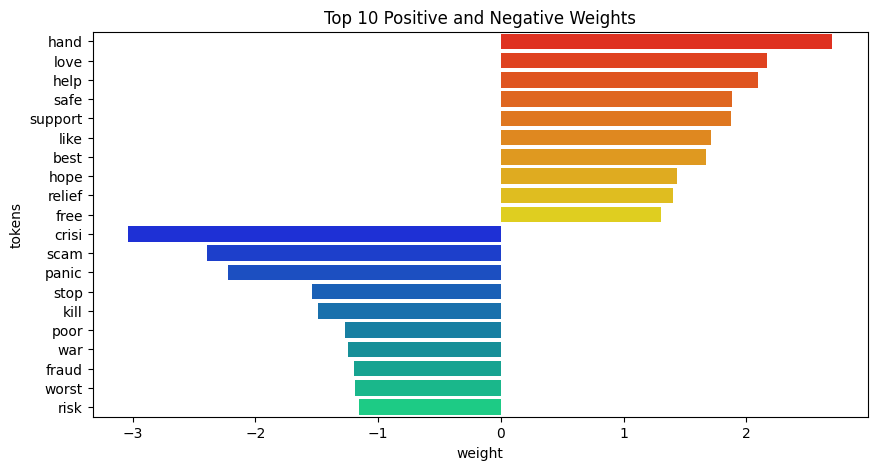

In [86]:
plt.figure(figsize=(10, 5))
sns.barplot(x='weight', y='tokens', data=top_positive, palette='autumn')
sns.barplot(x='weight', y='tokens', data=top_negative, palette='winter')
plt.title('Top 10 Positive and Negative Weights')
# plt.tight_layout()
plt.show()

**Ответ:** качество на тесте чуть ухудшилось, а на тренировочном - улучшилось, но скейлер не внес решающий вклад

про токены: большие положительные веса получили слова положительного окраса, а большие отрицательные - отрицательного, все логично, ведь нужно положительный ответ (число) в 1 случае и отрицательный ответ (число) в другом.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [46]:
train.UserName.value_counts().max()# все пользователи уникальны - значит это просто id - не несет пользы для модели
train.ScreenName.value_counts().max() # то же самое

1

**Ответ:** добавлять не буду

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [47]:
train.TweetAt.head()

,TweetAt
25621,06-04-2020
30135,10-04-2020
28899,09-04-2020
5989,19-03-2020
4367,18-03-2020


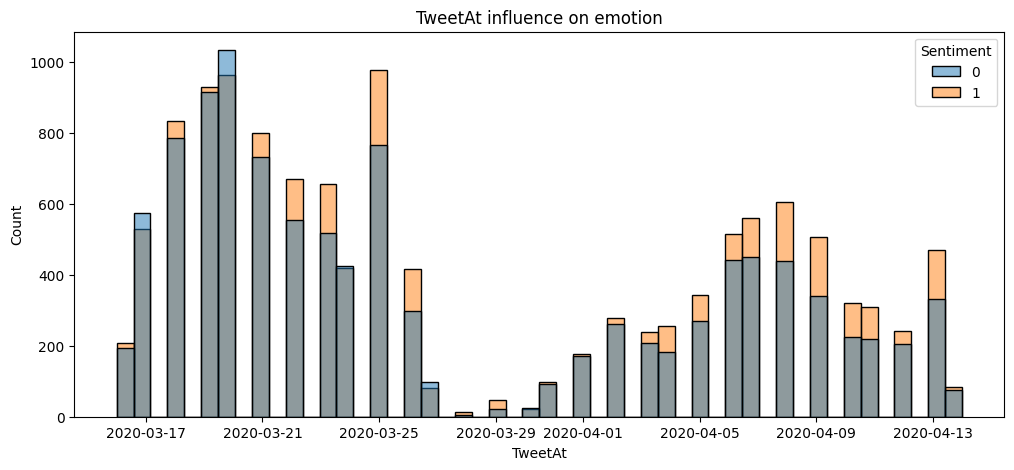

In [48]:
train.TweetAt = pd.to_datetime(train.TweetAt, format='%d-%m-%Y')

plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', bins=50)
plt.title('TweetAt influence on emotion')
plt.show()

**Ответ:** видим, что есть твиты обеих окрасок в каждый момент времени и так как положительных больше то и в каждый день среднем их чуть больше, вновь понимаем, что по этому признаку вряд ли удастся разделить - не добавляем

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [49]:
len(train.Location.unique()) #7949

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

Index(['London', 'United States', 'London, England', 'New York, NY',
       'Washington, DC', 'United Kingdom', 'Los Angeles, CA', 'India', 'UK',
       'Australia'],
      dtype='object', name='Location')


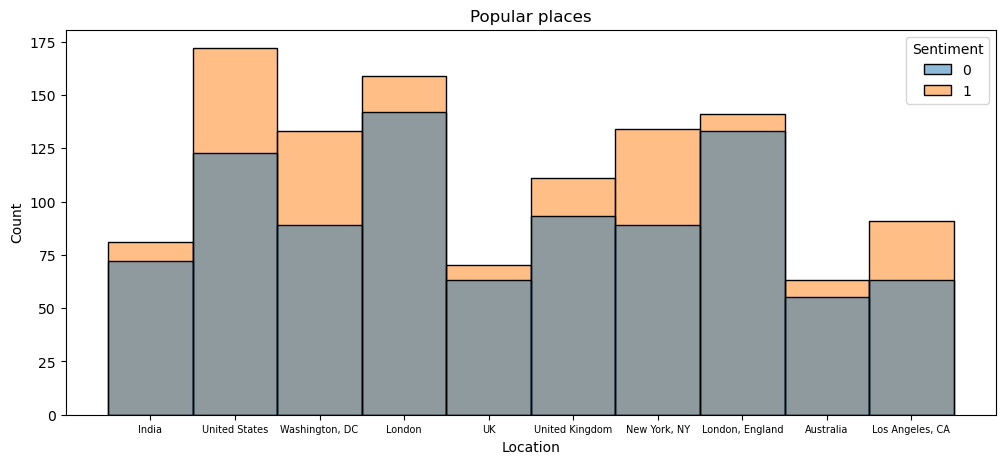

In [121]:
top_locations = train['Location'].value_counts().drop('Unknown', errors='ignore').head(10).index
print(top_locations)
places = train[train['Location'].isin(top_locations)]

plt.figure(figsize=(12, 5))
sns.histplot(data=places, x='Location', discrete=True, hue='Sentiment')
plt.xticks(fontsize=7)
plt.title('Popular places')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

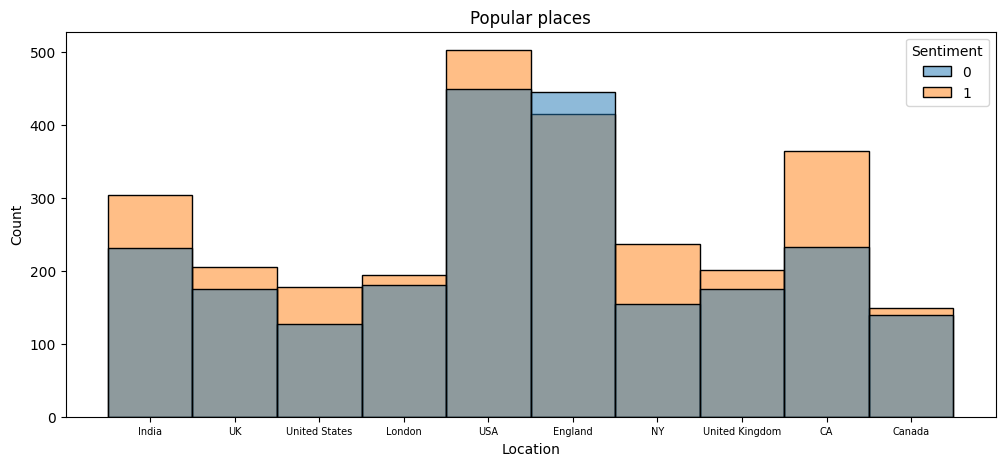

In [91]:
train.WiderLocation = train.Location.apply(lambda x: x.split(', ')[-1])
top_locations = train['Location'].value_counts().drop('Unknown', errors='ignore').head(10).index
places = train[train['Location'].isin(top_locations)]

plt.figure(figsize=(12, 5))
sns.histplot(data=places, x='Location', discrete=True, hue='Sentiment')
plt.xticks(fontsize=7)
plt.title('Popular places')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [72]:
location_counts = train.WiderLocation.value_counts()
top_locations = location_counts[location_counts > 1].index
top_locations = [i for i in top_locations if not '?'in i]
# я еще выкинул неясные локации, так как это сродни unknown
encoded_train = pd.get_dummies(train.WiderLocation.where(train.WiderLocation.isin(top_locations)).fillna('Other'),
                           prefix='WiderLocation')

encoded_train = encoded_train.drop(columns=['WiderLocation_Other'])
encoded_train = pd.concat([train, encoded_train], axis=1)
encoded_train.head()
len(top_locations)
# значений 975

975

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [106]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
#сделаем заново с помощью OneHotEncoder но с теми же широкими локациями
location_counts = train.WiderLocation.value_counts()
top_locations = location_counts[location_counts > 1].index
top_locations = [i for i in top_locations if not '?'in i]

train['WiderLocation'] = train.Location.apply(lambda x: x.split(', ')[-1])
test['WiderLocation'] = test.Location.apply(lambda x: x.split(', ')[-1])


enc = OneHotEncoder(categories=[top_locations],
                    sparse_output=True,
                    handle_unknown='ignore')

encoded_train = enc.fit_transform(train[['WiderLocation']])
encoded_test = enc.transform(test[['WiderLocation']])

train_encoded_sparse = csr_matrix(encoded_train)
X_train_cv_df = hstack([X_train_cv_df, train_encoded_sparse])

test_encoded_sparse = csr_matrix(encoded_test)
X_test_cv_df = hstack([X_test_cv_df, test_encoded_sparse])



In [107]:
clf = LogisticRegression(max_iter=200, random_state=52)

clf.fit(X_train_cv_df, y_train)
pred_train_cv_df = clf.predict(X_train_cv_df)
print('X_train_cv_df')
print(accuracy_score(y_train, pred_train_cv_df))

pred_test_cv_df = clf.predict(X_test_cv_df)
print('X_test_cv_df')
print(accuracy_score(y_test, pred_test_cv_df))

X_train_cv_df
0.9452370781717215
X_test_cv_df
0.8441299581423162


**Ответ:** качество почти не изменилось, признак - лишний